Use naive way to do the real data analysis

1. use cov
2. extract psd from 4 bands, and do regression

In [27]:
RUN_PYTHON_SCRIPT = False
#OUTLIER_IDXS = dict(AD=[], ctrl=[])
OUTLIER_IDXS = dict(AD=[49], ctrl=[14, 19, 30, 38])
SAVED_FOLDER = "real_data_nlinear_test"
DATA = ["AD88_PSD100_all.pkl", "Ctrl70_PSD100_all.pkl"]
#DATA = ["AD88_PSD89_all.pkl", "Ctrl92_PSD89_all.pkl"]

['AD88_PSD100_all.pkl', 'Ctrl70_PSD100_all.pkl']

In [28]:
import sys
sys.path.append("../../mypkg")


In [29]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import itertools

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
from IPython.display import display
from joblib import Parallel, delayed

In [30]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_sinica_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from hdf_utils.fns_sinica import  fourier_basis_fn

from joblib import Parallel, delayed

In [32]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [33]:
torch.set_default_tensor_type(torch.DoubleTensor)
def_dtype = torch.get_default_dtype()

torch.float64

# Load  data and prepare

In [34]:
data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/DATA[0]);
ctrl_PSD = load_pkl(data_root/DATA[1]);
df0= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv");
df1= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt_more.csv");
df1 = df1.set_index("RID")
df0 = df0.set_index("RID");
df1 = df1.reindex(df0.index)
baseline = df1

baseline["Gender_binary"] = baseline["Gender"].apply(lambda x: 0 if x=="female" else 1);
baseline["Grp_binary"] = baseline["Grp"].apply(lambda x: 1 if x=="AD" else 0);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_PSD100_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl70_PSD100_all.pkl


In [35]:
# The outlier idxs to rm
outlier_idxs = np.concatenate([OUTLIER_IDXS["AD"], len(AD_PSD.PSDs)+np.array(OUTLIER_IDXS["ctrl"])])
outlier_idxs = outlier_idxs.astype(int)

# make PSD in dB and std 
raw_X = np.concatenate([AD_PSD.PSDs, ctrl_PSD.PSDs]); #n x d x npts
X_dB = 20*np.log10(raw_X);
outlier_idxs2 = np.where(X_dB.mean(axis=(1, 2))<0)
#X = (X_dB - X_dB.mean(axis=-1, keepdims=1))/X_dB.std(axis=-1, keepdims=1);
X = X_dB

#Y = np.array(baseline["MMSE"])[:X.shape[0]];
# if logi
Y = np.array(baseline["Grp_binary"])[:X.shape[0]];

sel_cov = ["Gender_binary", "MEG_Age","Education"]
Z_raw = np.array(baseline[sel_cov])[:X.shape[0]];

grp_idxs = np.array(baseline["Grp"])[:X.shape[0]];

outlier_idxs = np.sort(np.union1d(outlier_idxs, outlier_idxs2))

# remove outliers
X = np.delete(X, outlier_idxs, axis=0)
Y = np.delete(Y, outlier_idxs, axis=0)
Z_raw = np.delete(Z_raw, outlier_idxs, axis=0)
grp_idxs = np.delete(grp_idxs, outlier_idxs, axis=0)


#remove nan
keep_idx = ~np.bitwise_or(np.isnan(Y), np.isnan(Z_raw.sum(axis=1)));
X = X[keep_idx];
Y = Y[keep_idx]
Z_raw = Z_raw[keep_idx]
grp_idxs = grp_idxs[keep_idx]

Z = np.concatenate([np.ones((Z_raw.shape[0], 1)), Z_raw], axis=1); # add intercept


print(X.shape, Y.shape, Z.shape)

all_data = edict()
all_data.X = torch.tensor(X+np.random.randn(*X.shape)*0.0)
all_data.Y = torch.tensor(Y)
all_data.Z = torch.tensor(Z)

freqs = AD_PSD.freqs;

(144, 68, 100) (144,) (144, 4)


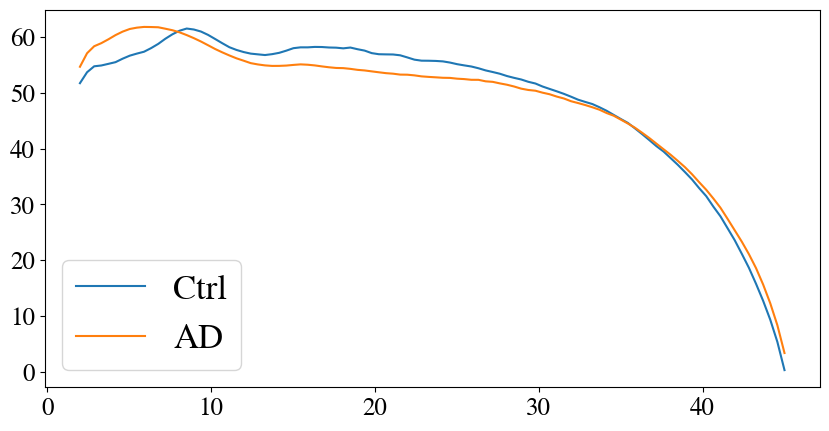

In [36]:
vec1 = all_data.X[grp_idxs=="AD"].mean(axis=(0, 1))
vec2 = all_data.X[grp_idxs=="Ctrl"].mean(axis=(0, 1))
plt.plot(freqs, vec2, label="Ctrl")
plt.plot(freqs, vec1, label="AD")
plt.legend()

In [37]:
# atlas
rois = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);

# Param and fns

## Params

In [38]:
save_dir = RES_ROOT/SAVED_FOLDER
if not save_dir.exists():
    save_dir.mkdir()

In [39]:
bands_cut = edict()
bands_cut.delta = [1, 4]
bands_cut.theta = [4, 8]
bands_cut.alpha = [8, 12]
bands_cut.beta = [12, 35]
bands_cut.pts = [4, 8, 12, 35]

freqs = AD_PSD.freqs.reshape(-1)
cut_pts = np.abs(freqs.reshape(-1, 1) - bands_cut.pts).argmin(axis=0)

kys = ["delta", "theta", "alpha", "beta", "all"]

['delta', 'theta', 'alpha', 'beta', 'all']

In [40]:
import matplotlib.patches as mpatches
from nilearn import plotting
import matplotlib as mpl
from utils.brain_plot import get_bg_data
def _brain_plot(vec, cmap="Reds", threshold=None):
    root = DATA_ROOT/"dk68_utils/"
    h = 0.43
    
    XYZsl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_left.txt")
    facesl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_left.txt").astype(np.int64)
    roi_tmpl = np.loadtxt(root/"brain_tmp_left_DK68.txt");
    bg_datal = get_bg_data(XYZsl, facesl)
    
    XYZsr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_right.txt")
    facesr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_right.txt").astype(np.int64)
    roi_tmpr = np.loadtxt(root/"brain_tmp_right_DK68.txt");
    bg_datar = get_bg_data(XYZsr, facesr)
    
    # map vec to the template
    vecl = roi_tmpl.copy()
    vecr = roi_tmpr.copy()
    for roi_ix in range(1, 35):
        vecl[roi_tmpl==roi_ix] = vec[roi_ix-1]
        vecr[roi_tmpr==roi_ix] = vec[roi_ix-1+34]
        
    vmin, vmax = np.min(vec), np.max(vec)
    #fig, axs = plt.subplots(2, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
    fig = plt.figure(figsize=(10, 10))
    # left, bottom, width, height
    # facecolor make the bg  transparent
    ax1 = fig.add_axes([0.1,  0.5, h,  h], projection='3d',  facecolor='none')
    ax2 = fig.add_axes([0.15, 0.1, h,  h], projection='3d',  facecolor='none') 
    ax3 = fig.add_axes([0.5,  0.5, h,  h], projection='3d',  facecolor='none')
    ax4 = fig.add_axes([0.47, 0.1, h,  h], projection='3d',  facecolor='none')  
    
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="lateral", axes=ax1, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal, # TO get the depth of the brain plot
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="medial", axes=ax2, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="lateral", axes=ax3, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="medial", axes=ax4, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    
    fig.text(0.12, 0.30, 'Medial', ha='center', va='center')
    fig.text(0.12, 0.72, 'Lateral', ha='center', va='center')
    fig.text(0.30, 0.87, 'Left', ha='center', va='center')
    fig.text(0.72, 0.87, 'Right', ha='center', va='center')
    plt.suptitle("-log pvalues", fontsize=30)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    fig.colorbar(sm, cax=cbar_ax)
    return fig

In [41]:
def _get_psd_X(X, kys):
    """From raw X to get the features with PSD
    """
    X_psd = []
    for ky in kys:
        if not ky.startswith("all"):
            cuts = bands_cut[ky]
            kpidxs = np.bitwise_and(freqs>=cuts[0], freqs <=cuts[1])
            X_sub = X[:, kpidxs].mean(axis=-1)
        else:
            X_sub = X.mean(axis=-1)
        X_psd.append(X_sub)
        
    X_psd = np.array(X_psd).T
    return X_psd

def _prepare_data(all_data, roi_ix, kys):
    """Prepare data for linear reg with roi_ix 
    args:
        roi_ix: start from 0
    return:
        Ycen: Y is centered
        Zext_std:Z is stded and has intercept col
    """
    X = all_data.X[:, roi_ix].numpy()
    Y = all_data.Y.numpy()
    Z = all_data.Z.numpy()
    X_psd = _get_psd_X(X, kys=kys)
    Zext = np.concatenate([Z, X_psd], axis=1)
    
    # center Y and std Zest
    Ycen = Y - Y.mean()
    Zext_std = np.ones_like(Zext)
    Zext_std[:,2:] = (Zext[:, 2:] - Zext[:, 2:].mean(axis=0, keepdims=1))/Zext[:, 2:].std(axis=0, keepdims=1)
    Zext_std = pd.DataFrame(Zext_std, columns=["int", "gender", "age", "edu"]+kys)
        
    return Ycen, Zext_std

In [42]:
kys = ["delta", "theta", "alpha", "beta", "all"]


['delta', 'theta', 'alpha', 'beta', 'all']

In [53]:
import statsmodels.api as sm
roi_ix = 0
kys = ["beta"]
vec = []
for roi_ix in range(68):
    Y, X = _prepare_data(all_data, roi_ix=roi_ix, kys=kys);
    X = X.drop(["age", "gender", "edu"], axis=1)
    model0 = sm.OLS(Y, X).fit()
    Xreduce = X.drop(kys, axis=1)
    model1 = sm.OLS(Y, Xreduce).fit()
    lr_test_res = model0.compare_lr_test(model1)
    pval = lr_test_res[1]
    if pval<0.05/68:
        print(roi_ix if roi_ix < 34 else roi_ix-34, lr_test_res)
        vec.append(-np.log(pval))
    else:
        vec.append(0)
vec = np.array(vec)

3 (15.22434996987181, 9.546452682366383e-05, 1.0)
7 (14.934755933483672, 0.0001112936466505896, 1.0)
10 (13.954259951501456, 0.00018731271536996018, 1.0)
22 (13.500494805484635, 0.0002385005566954261, 1.0)
25 (19.34197916588508, 1.0927728845119622e-05, 1.0)
29 (15.260421401245878, 9.365855193981917e-05, 1.0)
31 (12.700033967085915, 0.0003656489338350499, 1.0)
3 (18.114427705837045, 2.0801926877288313e-05, 1.0)
10 (11.91043640659501, 0.0005582032130066212, 1.0)
21 (11.952105347875118, 0.0005458566532111762, 1.0)
25 (13.734112185671165, 0.00021059460122185272, 1.0)
29 (22.21437014816115, 2.438419181960246e-06, 1.0)


array([ 0.        ,  0.        ,  0.        ,  9.25675583,  0.        ,
        0.        ,  0.        ,  9.10333838,  0.        ,  0.        ,
        8.58273106,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  8.34113891,  0.        ,  0.        ,
       11.42420707,  0.        ,  0.        ,  0.        ,  9.27585482,
        0.        ,  7.91383688,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 10.78046494,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  7.49078748,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        7.51315416,  0.        ,  0.        ,  0.        ,  8.46557559,
        0.        ,  0.        ,  0.        , 12.9241606 ,  0.        ,
        0.        ,  0.        ,  0.        ])

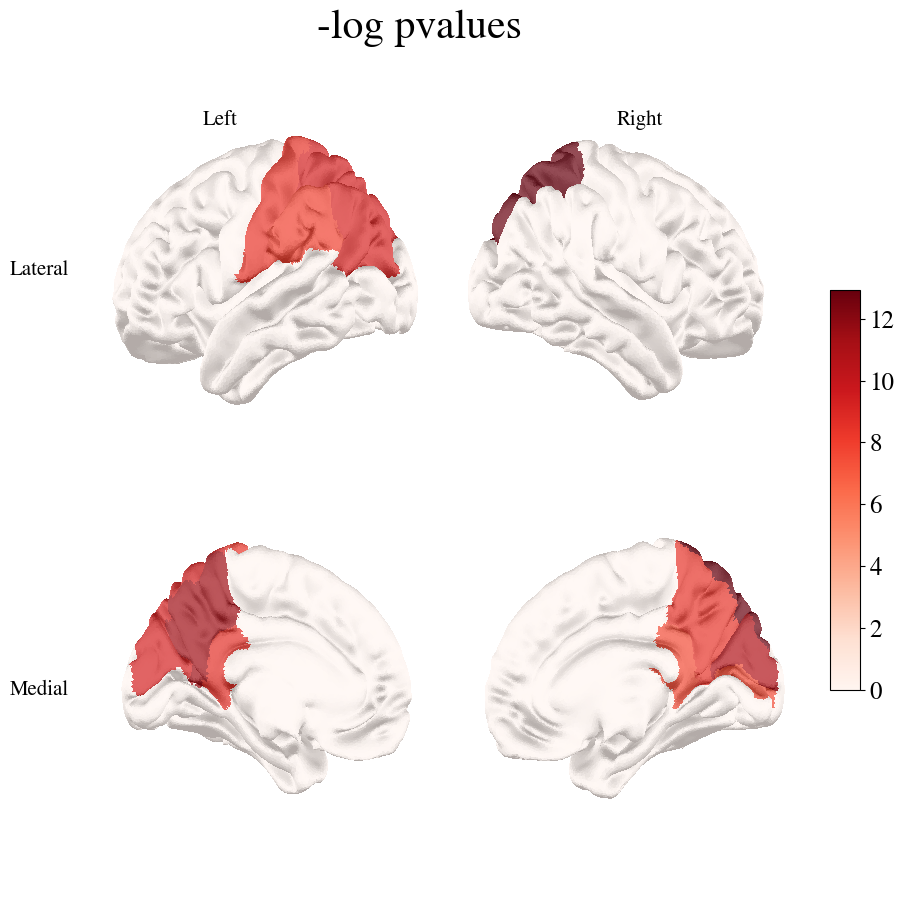

In [54]:
cmap = "Reds"
fig = _brain_plot(vec, cmap=cmap);